### **Mount Google Drive:**



In [1]:
#reference : https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Imports:**

In [2]:
# import tensorflow, keras, models
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

# import and display image
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# keras layers import
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply

# keras application and regularizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Layer, Conv2D, GlobalAveragePooling2D, Dense, Multiply, Add, Reshape, Permute, Activation,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2

# keras Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# utils and pre-processing
from tensorflow.keras.utils import load_img, img_to_array
from tf.keras.applications.mobilenet import preprocess_input

### **Defining batch and image size:**

In [3]:
import tensorflow as tf
# Define the data directory and other parameters
data_dir = '/content/drive/MyDrive/STATE_FARM_DATASET/train'

batch_size = 64
image_size = (224, 224)

### **Data Augmentation using Image Generator:**

In [4]:
#reference: https://stackoverflow.com/questions/49019929/keras-imagedatagenerator-preprocessing
# Create an instance of the ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        horizontal_flip=False,
        fill_mode="nearest",
        validation_split=0.20)

# Create a TensorFlow Dataset from the State Farm dataset directory
train_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb",
    subset='training',
    shuffle=True,
    seed=42
)
val_dataset = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode="rgb",
    subset='validation',
    shuffle=True,
    seed=42
)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


### **Display Augmented Images:**

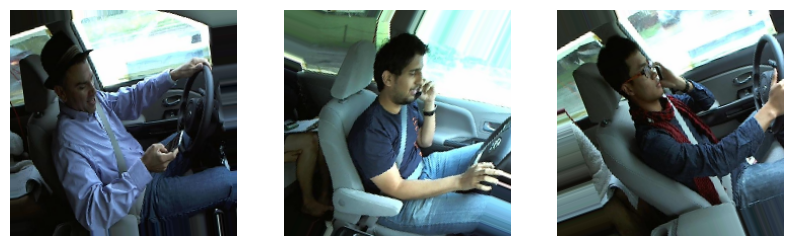

In [5]:
# reference:https://www.tensorflow.org/tutorials/images/classification
plt.figure(figsize=(10, 10))
for i in range(3):
    augmented_img, _ = next(train_dataset)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_img[0].astype(np.uint8))
    plt.axis('off')
plt.show()

### **Convolutional Block Attention Mechanism:**


*   Implemented spatial and channel attention
*   Convolutional 2D layer of filter = 1
*   Kernel size - 3x3



In [ ]:
#reference: https://github.com/nikhilroxtomar/Attention-Mechanism-Implementation/blob/main/TensorFlow/cbam.py
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling 2D
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling 2D
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv2D layer, filter size = 1
    feats = Conv2D(1, kernel_size=(3, 3), padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

### **Load pre-trained MobileNetV3Large model. Fine tuning the model with hyperparameter settings.**



*   Input = (224,224,3)
*   GlobalAveragePooling2D
*   Dense Layers 512-256
*   Dropout value - 0.2



In [ ]:
# Load the pre-trained MobileNetV3 model
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
# Create a new input tensor for the model
inputs = tf.keras.Input(shape=(224, 224, 3))

# Output of the MobileNetV3 model
mobilenet_output = base_model(inputs)

# Applying CBAM on top of MobileNetV3 output
cbam_output = cbam(mobilenet_output)

# classification head
x = GlobalAveragePooling2D()(cbam_output)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model summary
model.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 7, 7, 960)    2996352     ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 960)         0           ['MobilenetV3large[0][0]']       
 alAveragePooling2D)                                                                              
                             

### **Model Compilation:**


*   Adam Optimiser - learning rate = 0.001

*   Loss - Categorical crossentropy
*   Metrics - Accuracy


*   Early Stopping - Patience = 5



In [ ]:
# Compile the model
#reference: https://keras.io/api/callbacks/model_checkpoint/
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])
checkpointer = ModelCheckpoint('/content/drive/MyDrive/best_models/mobilenetV3_cbam512_256lr1e3_batchsize64_finalv1.0.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss',patience=5, min_delta = 0.001, verbose = 1,  restore_best_weights=True)

### **Model Training:**

*   Epochs = 25


In [ ]:
# Training the model
model.fit(train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=25,
    validation_data=val_dataset,
    validation_steps=val_dataset.samples // val_dataset.batch_size,callbacks=[es,checkpointer])

Epoch 1/25
280/280 [==============================] - ETA: 0s - loss: 1.4069 - accuracy: 0.4980
Epoch 1: val_loss improved from inf to 0.62286, saving model to /content/drive/MyDrive/best_models/mobilenetV3_cbam512_256lr1e2_batchsize64_finalv1.0.hdf5
280/280 [==============================] - 371s 1s/step - loss: 1.4069 - accuracy: 0.4980 - val_loss: 0.6229 - val_accuracy: 0.7879
Epoch 2/25
280/280 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.8376
Epoch 2: val_loss improved from 0.62286 to 0.24471, saving model to /content/drive/MyDrive/best_models/mobilenetV3_cbam512_256lr1e2_batchsize64_finalv1.0.hdf5
280/280 [==============================] - 368s 1s/step - loss: 0.4802 - accuracy: 0.8376 - val_loss: 0.2447 - val_accuracy: 0.9199
Epoch 3/25
280/280 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8939
Epoch 3: val_loss improved from 0.24471 to 0.20257, saving model to /content/drive/MyDrive/best_models/mobilenetV3_cbam512_256lr1e2_ba

### **Save the best model:**

In [7]:
# Load the best model from the saved checkpoint
#reference:https://keras.io/api/callbacks/model_checkpoint/
best_model = tf.keras.models.load_model('/content/drive/MyDrive/best_models/mobilenetV3_cbam512_256lr1e3_batchsize32_finalv1.0.hdf5')

### **Model Training and Validation Loss:**

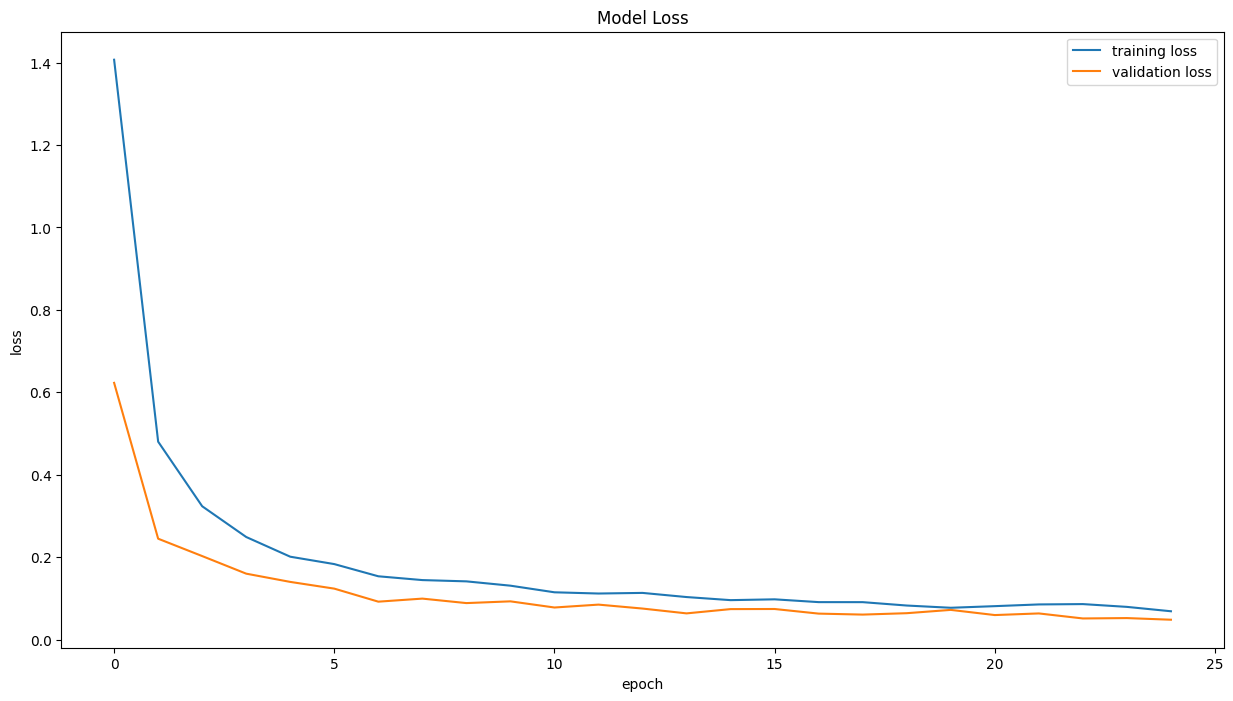

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss','validation loss'], loc='upper right')
plt.show()

### **Model Training and Validation Accuracy:**

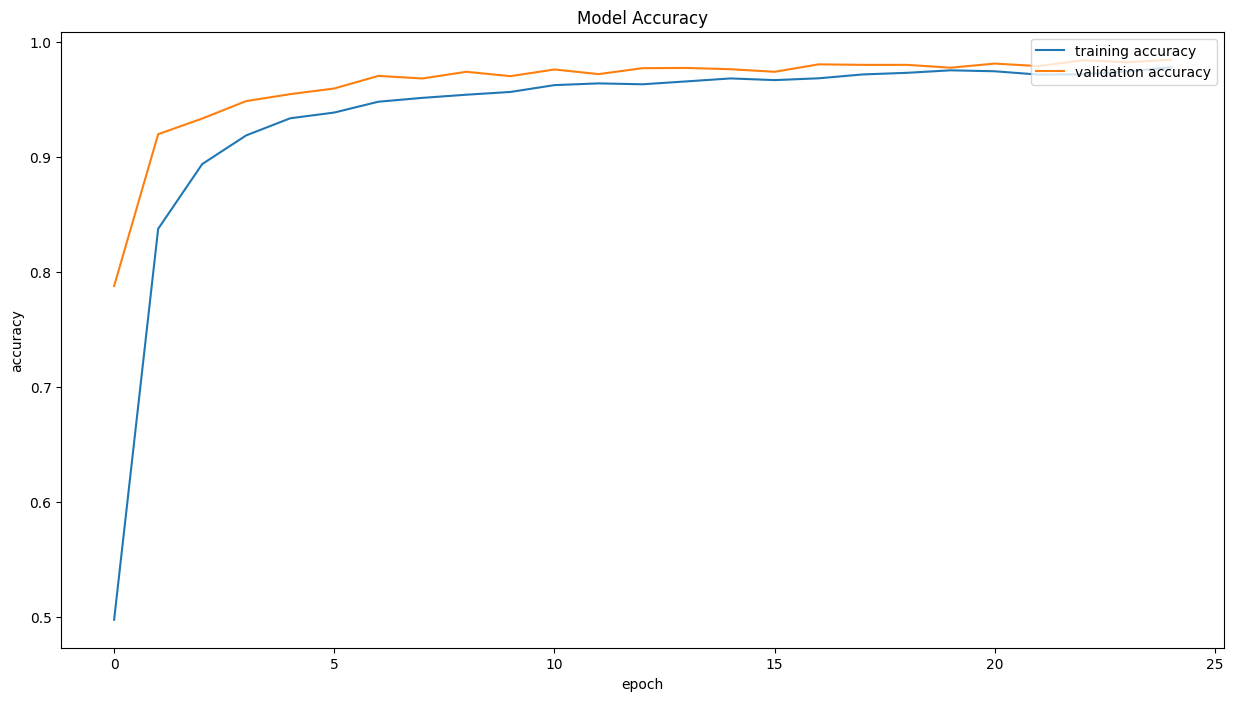

In [ ]:
fig = plt.figure(figsize = (15,8))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy','validation accuracy'], loc='upper right')
plt.show()

### **Evaluate the model:**

In [6]:
val_loss, val_accuracy = best_model.evaluate(val_dataset,steps=val_dataset.samples // val_dataset.batch_size,verbose=1)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

70/70 [==============================] - 1168s 17s/step - loss: 0.0687 - accuracy: 0.9759
Validation Loss: 0.0686882734298706
Validation Accuracy: 0.9758928418159485


### **Load test samples:**

In [8]:
test_dir1 = "/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1"
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_dir1,
    target_size=image_size,
    batch_size=8,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 220 images belonging to 10 classes.


### **Confusion Matrix - Test Data**

28/28 [==============================] - 53s 2s/step


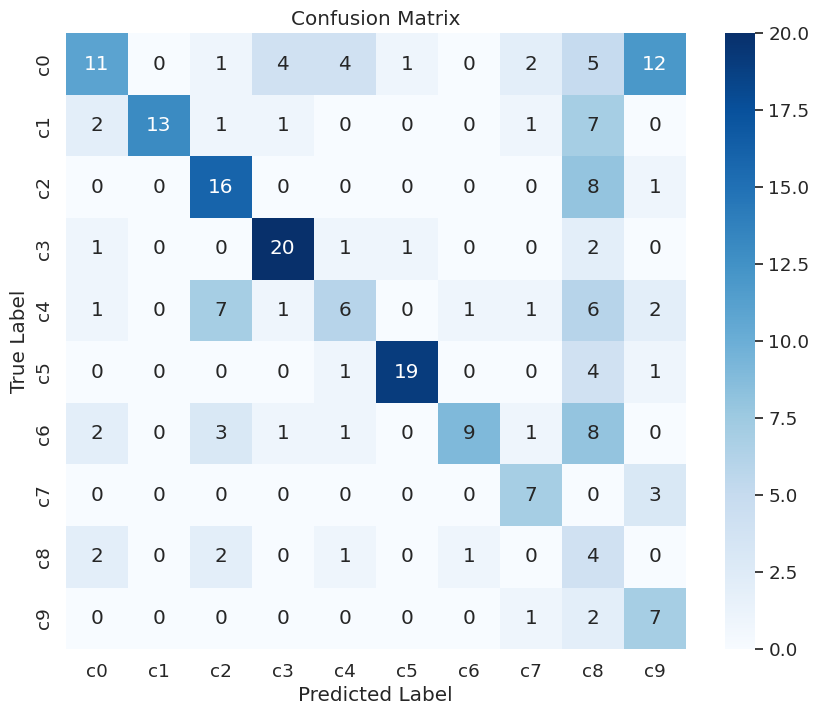

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_generator.classes

num_classes = len(test_generator.class_indices)
predictions = best_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
conf_matrix_test = confusion_matrix(true_labels, predicted_labels)

#reference: https://stackoverflow.com/questions/61526287/how-to-add-correct-labels-for-seaborn-confusion-matrix
# Plot the confusion matrix heatmap with counts inside
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **Test Accuracy per Class:**

In [11]:
#reference:https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
def calculate_per_class_accuracy_test(conf_matrix):
    num_classes = conf_matrix.shape[0]
    accuracy_dict = {}

    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        total_predictions = sum(conf_matrix[i, :])
        accuracy = true_positive / total_predictions

        accuracy_dict[i] = accuracy

    return accuracy_dict

per_class_accuracy = calculate_per_class_accuracy_test(conf_matrix_test)
class_names = ["c0", "c1", "c2","c3","c4","c5","c6","c7","c8","c9"]  # Replace with your class names

for i, class_name in enumerate(class_names):
    print(f"Accuracy for {class_name}: {per_class_accuracy[i]:.4f}")

mean_accuracy = sum(per_class_accuracy.values()) / len(per_class_accuracy)
print(f"Overall Mean Accuracy: {mean_accuracy:.4f}")


Accuracy for c0: 0.2750
Accuracy for c1: 0.5200
Accuracy for c2: 0.6400
Accuracy for c3: 0.8000
Accuracy for c4: 0.2400
Accuracy for c5: 0.7600
Accuracy for c6: 0.3600
Accuracy for c7: 0.7000
Accuracy for c8: 0.4000
Accuracy for c9: 0.7000
Overall Mean Accuracy: 0.5395


### **Get Class Labels:**

In [30]:
def get_labels(predicted_label_index):

  if predicted_label_index == 1:
    return "Safe driving"
  elif predicted_label_index == 2:
    return "Text right"
  elif predicted_label_index == 3:
    return "Talk right"
  elif predicted_label_index == 4:
    return "Text left"
  elif predicted_label_index == 5:
    return "Audio system"
  elif predicted_label_index == 6:
    return "Drink"
  elif predicted_label_index == 7:
    return "Reach Behind"
  elif predicted_label_index == 8:
    return "Hair-Makeup"
  else:
    return "Talk to passenger"




### **Check Predictions:**


*   Correctly predicted labels



1/1 [==============================] - 0s 40ms/step


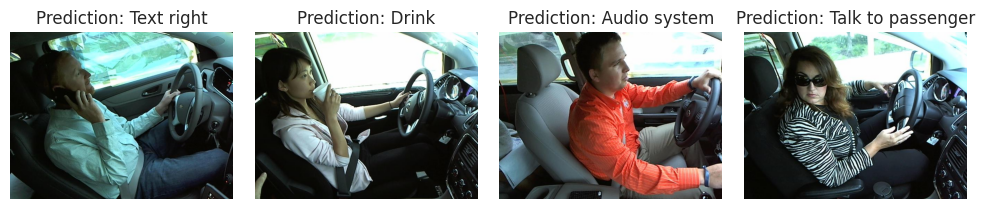

In [40]:
image_paths = [
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c2/img_160.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c6/img_405.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c5/img_318.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c9/img_57.jpg'
]

# Create a figure with multiple subplots arranged horizontally
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

# Loop through image paths
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image
    my_image = load_img(img_path, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, axis=0)
    my_image = preprocess_input(my_image)

    # Make the prediction
    prediction_single = best_model.predict(my_image)
    predicted_label_index = np.argmax(prediction_single)

    predicted_label = get_labels(predicted_label_index)

    # Load the image using plt.imread
    img = plt.imread(img_path)

    # Plot the image on a subplot
    axes[i].imshow(img)
    axes[i].set_title(f'Prediction: {predicted_label}',size = 12)
    axes[i].axis('off')

# Adjust layout spacing between subplots
plt.tight_layout()
plt.show()


### **Check Predictions:**


*   False positives



1/1 [==============================] - 0s 40ms/step


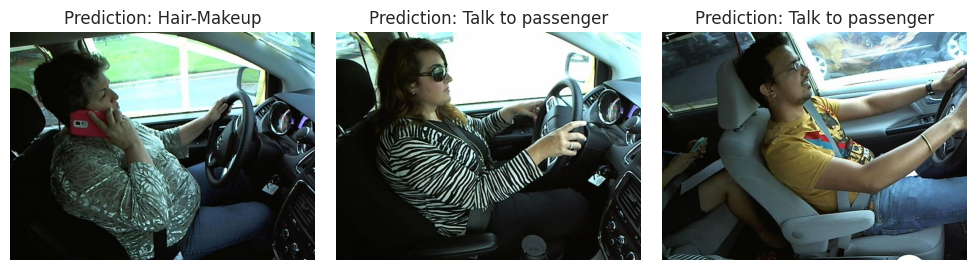

In [47]:
image_paths = [
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c2/img_161.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c0/img_101884.jpg',
    '/content/drive/MyDrive/STATE_FARM_DATASET/TEST_FOLDER/manual_testdataset02/state_farm_dataset1/c0/img_101937.jpg',
]

# Create a figure with multiple subplots arranged horizontally
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

# Loop through image paths
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image
    my_image = load_img(img_path, target_size=(224, 224))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, axis=0)
    my_image = preprocess_input(my_image)

    # Make the prediction
    prediction_single = best_model.predict(my_image)
    predicted_label_index = np.argmax(prediction_single)

    predicted_label = get_labels(predicted_label_index)

    # Load the image using plt.imread
    img = plt.imread(img_path)

    # Plot the image on a subplot
    axes[i].imshow(img)
    axes[i].set_title(f'Prediction: {predicted_label}',size = 12)
    axes[i].axis('off')

# Adjust layout spacing between subplots
plt.tight_layout()
plt.show()
